<a href="https://colab.research.google.com/github/avocadopelvis/BTP/blob/main/lung-segmentation/ls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# !pip install keras_unet_collection

In [5]:
# load libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import cv2
from cv2 import imread, createCLAHE
from tqdm import tqdm
from glob import glob

In [6]:
# dataset path
image_path = os.path.join("/content/drive/MyDrive/BTP/LUNG SEGMENTATION/DATASET/CXR_png")
mask_path = os.path.join("/content/drive/MyDrive/BTP/LUNG SEGMENTATION/DATASET/masks")

#### Since we have 800 images but only 704 masks, we will make a 1-1 correspondence from masks to images

In [7]:
image = os.listdir(image_path)
mask = os.listdir(mask_path)
# get the file name of each mask and store in a list
masks = [fName.split(".png")[0] for fName in mask]
# get the corresponding image file name for each mask and store in a list
images = [fName.split("_mask")[0] for fName in masks]

In [8]:
check = [i for i in masks if "mask" in i]
print("Total mask that has modified name:", len(check))

Total mask that has modified name: 566


In [9]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

# function to get data
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array
    
    
# function to perform sanity check
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [10]:
# load data
dim = 256*2
X_train, y_train = getData(dim, flag = 'train')
X_test, y_test = getData(dim)

100%|██████████| 138/138 [02:23<00:00,  1.04s/it]


### Perform Sanity Check

training set


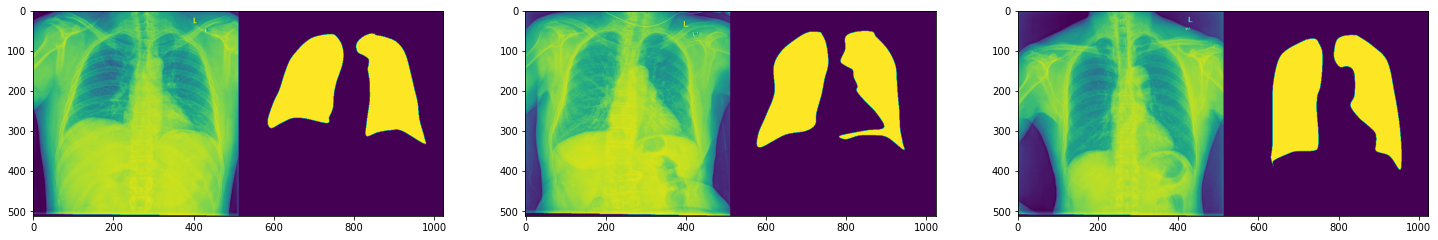

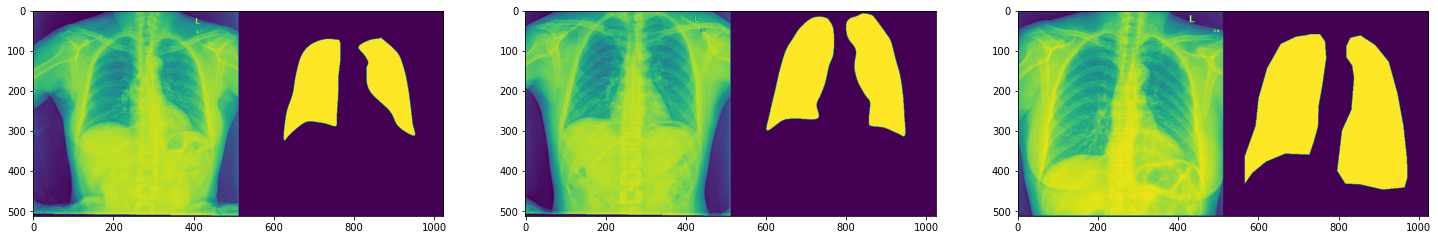

testing set


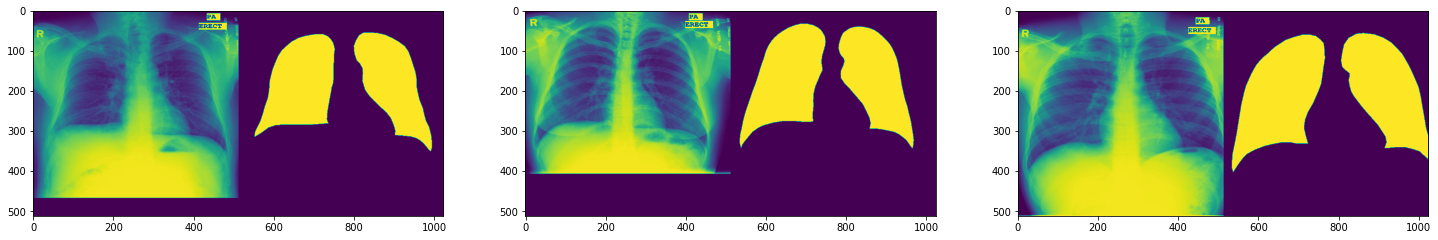

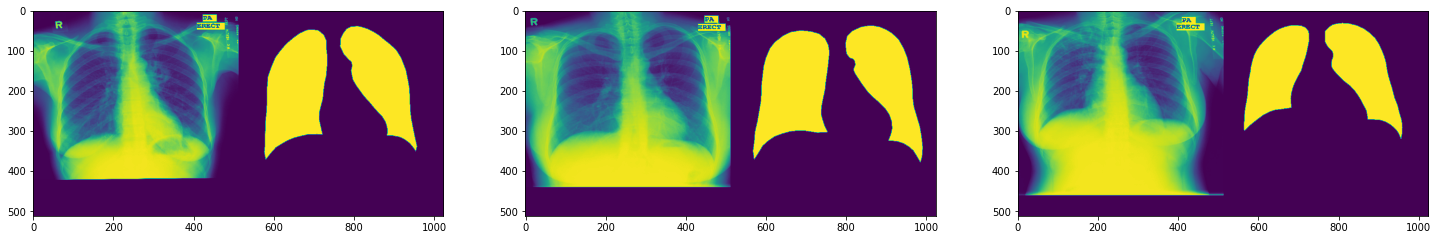

In [11]:
print("training set")
plotMask(X_train, y_train)
print('testing set')
plotMask(X_test, y_test)

#### Since both the sets look correct, we will combine them and use it as a unified dataset

In [12]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
y_train = np.array(y_train).reshape(len(y_train), dim, dim, 1)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
y_test = np.array(y_test).reshape(len(y_test), dim, dim, 1)

assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape

images = np.concatenate((X_train, X_test), axis = 0)
masks = np.concatenate((y_train, y_test), axis = 0)

In [13]:
from keras.models import *
from keras.layers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [14]:
from tensorflow.keras.optimizers import *
from keras_unet_collection import models

model = models.unet_2d((512, 512, 1), [32, 64, 128, 256, 512], 2)
# model.compile(optimizer = Adam(learning_rate = 1e-5), 
#               loss = dice_coef_loss,
#               metrics = [dice_coef, 'binary_accuracy'])
# model.summary()

model.compile(optimizer = Adam(learning_rate = 2e-4),
              loss = [dice_coef_loss],
              metrics = [dice_coef, 'binary_accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

callbacks = [checkpoint, early, reduceLROnPlat]

In [2]:
from sklearn.model_selection import train_test_split

# train and validation
train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, (masks>127).astype(np.float32), test_size = 0.1, random_state = 42)
# train and test
train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol, train_seg, test_size = 0.1, random_state = 42)

history = model.fit(train_vol, train_seg,
                    epochs = 50,
                    validation_data = (validation_vol, validation_seg),
                    callbacks = callbacks)
